In [84]:
import os
import pandas as pd
import wget
import sys
import subprocess
from subprocess import call
import matplotlib.pyplot as plt
%matplotlib inline

import random
import json

import numpy as np

from metamind.api import ClassificationData, ClassificationModel, set_api_key

sys.path.append(os.environ["HOME"])
from ds_config import *

print os.environ["HOME"]
MAIN_PATH = os.environ["HOME"]+"/GLaDOS_Workspace/"
#os.mkdir(MAIN_PATH)
#os.mkdir(MAIN_PATH+"Videos/")
#os.mkdir(MAIN_PATH+"Images/")

/Users/williamspearman


# FFMPEG Scrips

In [97]:
def getVideoInfo(file_name):
    bashCommand = "ffprobe -show_streams " + file_name
    process = subprocess.Popen(bashCommand.split(" "), stdout=subprocess.PIPE)
    output = process.communicate()[0].split("\n")
    ret_dict = { }
    for x in output:
        if "=" in x:
            key_vals = x.split("=")
            ret_dict[key_vals[0]] = key_vals[1]
    #print ret_dict
    return ret_dict

def getRandInt(int1, int2):
    if int1[0]>=int1[1]:
        return np.random.randint(int2[0],int2[1])
    elif int2[0]>=int2[1]:
        return np.random.randint(int1[0],int1[1])
    
    if np.random.random() > 0.5:
        return np.random.randint(int1[0],int1[1])
    else:
        return np.random.randint(int2[0],int2[1])


def getGetPlayTriplet(file_name, snap_time, pm_secs=1., play_type="NONE", num_frames=5):
    """
    print "file_name %s" % file_name
    print "snap_time %f" % snap_time
    print "pm_secs %f" % pm_secs
    print "play_type %s" % play_type
    print "num_frames %i" % num_frames
    """
    ret_val = { }
    info_dict = getVideoInfo(file_name)
    required_vals = { "duration", "nb_frames", "avg_frame_rate", "sample_aspect_ratio" }
    if len(required_vals.intersection(set(info_dict.keys())))!=len(required_vals):
        print "Doesn't have required vals"
        return None
    frame_rate = 0.
    try:
        
        frame_rate = float(info_dict["avg_frame_rate"].split("/")[0])/float(info_dict["avg_frame_rate"].split("/")[1])
    except:
        print "Failed the splitting"
        return None
    max_frames = float(info_dict["nb_frames"])
    duration = float(info_dict["duration"])

    if int(max_frames/frame_rate-duration)!= 0:
        print "Cross check failed"
        return None
    
    
    #print "Frame_rate %f" % frame_rate
    low_nframes = (num_frames-1)/2.
    pm_frames = pm_secs * frame_rate
    snap_frame = snap_time * frame_rate
    snap_frame_low = snap_frame-low_nframes*pm_frames
    snap_frame_high = snap_frame+low_nframes*pm_frames
    #snap_frame_high = snap_frame+pm_frames
    """
    print "snap_frame %f" % snap_frame
    print "num_frames %f" % num_frames
    print "low_nframes %f" %low_nframes
    print pm_frames
    """
    if snap_frame_low<0:
        print "Snap frame too low: %i" % snap_frame_low
        return None
    if snap_frame_high>max_frames:
        print "Snap frame too high: %i" % snap_frame_high
        return None
    
    ret_val[play_type] = [ (snap_frame_low+i*pm_frames)/frame_rate for i in range(0,num_frames) ]
    #print ret_val[play_type]
    #ret_val[play_type] = [ snap_frame_low/frame_rate, snap_frame/frame_rate, snap_frame_high/frame_rate ]
    #ret_val["NOT_SNAP"] = [ (bkg_frame-pm_frames)/frame_rate, bkg_frame/frame_rate, (bkg_frame+pm_frames)/frame_rate ]
    
    return ret_val
    
def downloadUrl(url):
    base_name = ""
    try:
        base_name = url.split("/")[-1]
    except:
        return ""
    
    output_name = MAIN_PATH + "Videos/" + base_name
    if os.path.isfile(output_name)==False:
        wget.download(url, MAIN_PATH+"Videos/")
    
    if os.path.isfile(output_name)==True:
        return output_name
    else:
        return ""



def makeImageMontage(url, snap_time, time_offset=0.5, play_type="NONE", num_frames=5):
    ret_val = [ ]
    video_path = downloadUrl(url)
    #print "BLah %f" % 0.2
    base_name = ""
    try:
        base_name = video_path.split("/")[-1].split(".")[0]
    except:
        print "Failed splitting: %s" % video_path
        return None
    input_times = getGetPlayTriplet(video_path, snap_time, pm_secs=time_offset, play_type=play_type, num_frames=num_frames)
    if input_times==None:
        return ret_val
    #resolution = resolution.replace(":", "x")
    #name1 = "blah"
    #name2 = "blah"
    ffmpeg_cmds = { }
    file_names = { }
    for mykey in input_times.keys():
        output_name = MAIN_PATH + "Images/" + base_name
        ffmpeg_cmds[mykey] = [ ]
        file_names[mykey] = [ ]
        for x, i in zip(input_times[mykey], range(0,len(input_times[mykey]))):
            file_name = "%s_%i_%s.jpg" % (output_name, i, mykey)
            file_names[mykey].append(file_name)
            ffmpeg_cmds[mykey].append("ffmpeg -ss %f -i %s -vframes 1 %s 2> /dev/null" % (x, video_path, file_name))
            #print ffmpeg_cmds[mykey][-1]
        #montage_cmd = "montage -tile 1x3 -geometry 512x256+0+0 "
        montage_cmd = "montage -tile 1x%i -geometry 512x+0+0 " % (num_frames)
        for thecmd, fname in zip(ffmpeg_cmds[mykey], file_names[mykey]):
            call(thecmd, shell=True)
            montage_cmd = montage_cmd+fname+" "
        montage_name = "%s_%i_%s_MONTAGE.jpg" % (output_name, int(1000*input_times[mykey][1]), mykey)
        montage_cmd = montage_cmd + " " + montage_name
        #print montage_cmd
        call(montage_cmd,shell=True)
        for fname in file_names[mykey]:
            os.remove(fname)
            #print "BLAH"
            
        ret_val.append((montage_name, mykey))
    os.remove(video_path)
    return ret_val[0]

In [56]:
print makeImageMontage("http://vf.hudl.com/9n6/81k/bab387d7-c875-4df6-89f7-3a0c910deb6a/lelyp36kuaykgm1j-3000_1100.mp4"\
                       , 8.809, time_offset=0.5, num_frames=10)

[('/Users/williamspearman/GLaDOS_Workspace/Images/lelyp36kuaykgm1j-3000_1100_7058_NONE_MONTAGE.jpg', 'NONE')]


In [58]:
fullRDD = sc.textFile("s3n://hudl-hadoop/GLaDOS/snap_detect_data/").map(json.loads)

In [98]:
fullRDD_size = fullRDD.count()
trainNum = 4000
testNum = 100

train_arr = fullRDD.sample(False, (trainNum+100.)/fullRDD_size).collect()[:trainNum]
test_arr = fullRDD.sample(False, (testNum+100.)/fullRDD_size).collect()[:testNum]
#print 
#print snapRDD_test.count()

In [99]:
train_arr[1]

{u'data': u'Pass',
 u'video': {u'snap confidence': 1,
  u'snap time': 10.811,
  u'urls': [u'http://vc.hudl.com/4r2/gyw/3770f529-46aa-4752-a5d1-2c34e7c4a215/096-7hny.mp4',
   u'http://vc.hudl.com/4r2/gyw/3770f529-46aa-4752-a5d1-2c34e7c4a215/096-7hny_1100.mp4']}}

In [101]:
train_sample = [ ]
length=len(train_arr)
random.shuffle(train_arr)
for x, i in zip(train_arr, range(0,length)):
    if x["data"]=="Run" or x["data"]=="Pass":
        print "%i of %i" % (i, length)
        tmp = makeImageMontage(x["video"]["urls"][-1],x["video"]["snap time"], time_offset=0.5, num_frames=7, play_type=x["data"])
        if len(tmp)==1:
            #print tmp[0]
            train_sample.append(tmp[0])

0 of 4000
1 of 4000
2 of 4000
3 of 4000
Snap frame too low: 0
5 of 4000
6 of 4000
7 of 4000
8 of 4000
9 of 4000
Snap frame too low: -10
10 of 4000
11 of 4000
12 of 4000
13 of 4000
14 of 4000
15 of 4000
16 of 4000
Snap frame too low: 0
17 of 4000
18 of 4000
Failed the splitting
19 of 4000
20 of 4000
21 of 4000
Snap frame too low: -10
23 of 4000
24 of 4000
25 of 4000
26 of 4000
27 of 4000
Snap frame too low: 0
28 of 4000
29 of 4000
Snap frame too low: 0
30 of 4000
31 of 4000
32 of 4000
33 of 4000
34 of 4000
36 of 4000
37 of 4000
38 of 4000
39 of 4000
40 of 4000
41 of 4000
42 of 4000
43 of 4000
44 of 4000
45 of 4000
46 of 4000
Failed the splitting
47 of 4000
48 of 4000
49 of 4000
50 of 4000
51 of 4000
52 of 4000
53 of 4000
Snap frame too low: -10
54 of 4000
55 of 4000
56 of 4000
57 of 4000
58 of 4000
Snap frame too low: -10
59 of 4000
Failed the splitting
60 of 4000
61 of 4000
62 of 4000
63 of 4000
65 of 4000
66 of 4000
Failed the splitting
67 of 4000
68 of 4000
69 of 4000
70 of 4000
71 o

KeyboardInterrupt: 

In [102]:
def getInputs(path, formation):
    ret_val = [ ]
    for myfile in os.listdir(path):
        if formation in myfile:
            ret_val.append( ( os.path.join(path,myfile), formation) )
    return ret_val

In [103]:
run_input = getInputs("/Users/williamspearman/GLaDOS_Workspace/Images","Run")
pass_input = getInputs("/Users/williamspearman/GLaDOS_Workspace/Images","Pass")

min_len = min(len(run_input),len(pass_input))
input_data = run_input[:min_len]+pass_input[:min_len]
random.shuffle(input_data)

In [104]:
set_api_key(metamind_api_key)

Hello, William Spearman


In [105]:
training_data = ClassificationData(private=True, data_type="image", name="run_pass_large")

You are creating dataset 'run_pass_large', with id: 152276


In [107]:
training_data.add_samples(input_data, input_type="files")

Starting data upload...
Finished uploading 150 of 1052 samples...
Finished uploading 300 of 1052 samples...
Finished uploading 450 of 1052 samples...
Finished uploading 600 of 1052 samples...
Finished uploading 750 of 1052 samples...
Finished uploading 900 of 1052 samples...
Finished uploading 1050 of 1052 samples...
Finished uploading 1052 of 1052 samples...


In [ ]:
classifier = ClassificationModel(private=True, name="run_pass_large")

In [ ]:
#classifier.fit_async(training_data)
classifier.fit_async(training_data, options={"max_epochs" : 50, "stepsize_epochs" : 40})

In [5]:
classifier = ClassificationModel(id=18409)
training_data = ClassificationData(id=152216)
classifier.fit_async(training_data)

You are fetching dataset 'snap_detect', with id: 152216
Your MetaMind image model is now training on the server!


In [91]:
classifier.status()

u'running'

2.0047523547


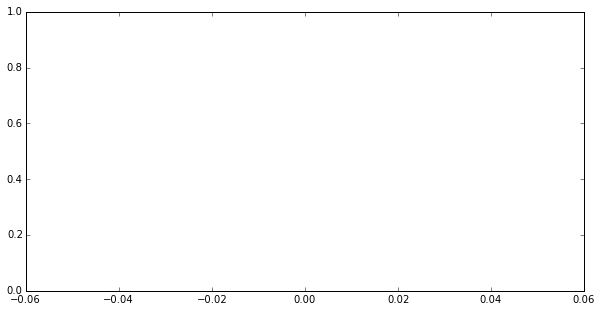

In [95]:
plt.figure(figsize=(10, 5))
print classifier.stats()["time_left"] / 60.

plt.plot(classifier.stats()["training_stats"]["train_accuracy"])
plt.ylim([0, 1])
plt.show() 


In [88]:
preds = classifier.predict(fg_test_set, input_type="files")

/home/ubuntu/anaconda/lib/python2.7/site-packages/requests/packages/urllib3/util/ssl_.py:79: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. For more information, see https://urllib3.readthedocs.org/en/latest/security.html#insecureplatformwarning.
  InsecurePlatformWarning
/home/ubuntu/anaconda/lib/python2.7/site-packages/requests/packages/urllib3/util/ssl_.py:79: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. For more information, see https://urllib3.readthedocs.org/en/latest/security.html#insecureplatformwarning.
  InsecurePlatformWarning
Traceback (most recent call last):
  File "/home/ubuntu/anaconda/lib/python2.7/site-packages/metamind/api/utils.py", line 34, in make_request
    return validate_result(response)
  File "/home/ubuntu/anac

In [94]:
preds = pd.DataFrame([
    classifier.predict(fg, input_type="files") for fg in fg_test_set
])

/home/ubuntu/anaconda/lib/python2.7/site-packages/requests/packages/urllib3/util/ssl_.py:79: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. For more information, see https://urllib3.readthedocs.org/en/latest/security.html#insecureplatformwarning.
  InsecurePlatformWarning
/home/ubuntu/anaconda/lib/python2.7/site-packages/requests/packages/urllib3/util/ssl_.py:79: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. For more information, see https://urllib3.readthedocs.org/en/latest/security.html#insecureplatformwarning.
  InsecurePlatformWarning
/home/ubuntu/anaconda/lib/python2.7/site-packages/requests/packages/urllib3/util/ssl_.py:79: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL 

In [102]:
pred_dicts = []

for d in preds.values:
    pred_dicts.append(d[0])

In [103]:
preds = pd.DataFrame(pred_dicts)

In [112]:
preds.groupby("label").label.count()

label
fg       153
punt      25
Name: label, dtype: int64